# EF5 Kinematic Wave Parameter Model Generation

In [1]:
%matplotlib inline
from sklearn import svm
from sklearn import preprocessing
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt

## Load & QC the Data

In [2]:
df = pd.read_csv('USGS_Data.csv')

# Do some basic QC on the data derived from USGS
df.dropna(inplace=True)
df = df[df.alpha < 1000.0]
df = df[df.beta < 1.1]
df = df[df.QICode == 0]
df = df[df.CC >0.8]

# Make sure we have good matches with USGS derived basin area & the basin area represented in the model grids
df['error'] = np.abs((df['model_basin_area'] - df['usgsdarea']) / df['usgsdarea'])
df = df[df.error < 0.1]

# We log some variables because they span huge ranges
df['lest_barea'] = np.log10(df['model_basin_area'])
df['lalpha'] = np.log10(df['alpha'])

# Final QC step
df = df[np.isfinite(df)]

# Target variables
usgs_alpha = df['lalpha']
usgs_beta = df['beta']

# This is the unlogged Alpha for plotting
usgs_alpha_real = df['alpha']

## These are the predictors we will use

In [3]:
pred = df[["lest_barea", "temp", "precip", "clay_pct", "sand_pct", "silt_pct", "rr", "frags", "bedrock", "imperv", "density", "population"]]

## Rescale the values to be between 0-1, and save so we can apply elsewhere

In [4]:
scaler = preprocessing.RobustScaler().fit(pred)
pickle.dump(scaler, open("output/scaler.p", "wb"))
pred = scaler.transform(pred)

## Fit Beta

In [5]:
clf = None
clf = svm.SVR(kernel='rbf', C=1e3, gamma=0.05)
clf.fit(pred, usgs_beta)
print(clf.score(pred, usgs_beta))
pickle.dump(clf, open("output/beta_model.p", "wb"))

0.562796427798


## Plot of Modeled vs Observed Beta

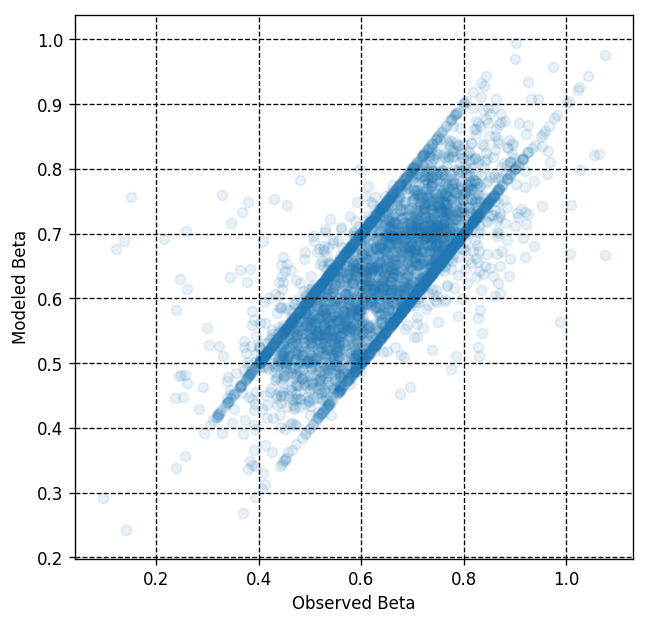

In [7]:
beta_pred = clf.predict(pred)
fig = plt.figure(figsize=(6,6),dpi=120)
ax = fig.add_subplot(111)
ax.yaxis.grid(True, color='black', linestyle='dashed')
ax.xaxis.grid(True, color='black', linestyle='dashed')
plt.scatter(usgs_beta, beta_pred, alpha=0.1)
plt.xlabel("Observed Beta")
plt.ylabel("Modeled Beta")
plt.show()

## Fit Alpha

In [8]:
clf2 = None
clf2 = svm.SVR(kernel='rbf', C=1e3, gamma=0.05)
clf2.fit(pred, usgs_alpha)
print(clf2.score(pred, usgs_alpha))
pickle.dump(clf2, open("output/alpha_model.p", "wb"))

0.762175574121


## Plot of Modeled vs Observed Alpha

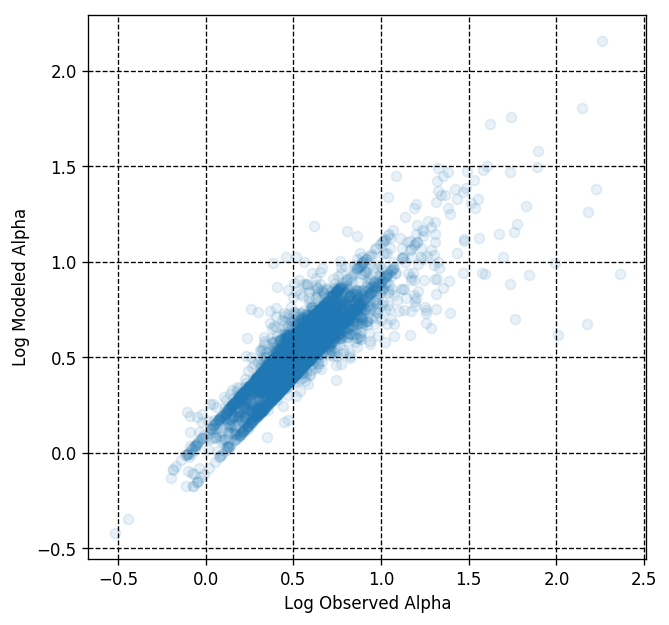

In [36]:
alpha_pred = clf2.predict(pred)
fig = plt.figure(figsize=(6,6),dpi=120)
ax = fig.add_subplot(111)
ax.yaxis.grid(True, color='black', linestyle='dashed')
ax.xaxis.grid(True, color='black', linestyle='dashed')
plt.scatter(usgs_alpha, alpha_pred, alpha=0.1)
plt.xlabel("Log Observed Alpha")
plt.ylabel("Log Modeled Alpha")
plt.show()